# Model deployment
We're going to make the model available for use. The metrics of focus are:
1.  Performs well (~95% accuracy)
2.  Fast inference timings (30ms latency)

## 1. Seting up for model experiments
* We are going to develop and choose from either the EffNetB2 and ViT feature extractor models for deployment.
* Thereafter we're going to finetune the chosen model on the entire FoodVision dataset

In [21]:
import os
from pathlib import Path

import sys
sys.path.append("../")
from src.utils import get_device, plot_loss_curves
from going_modular import data_setup, engine
from going_modular.get_data import get_data
from going_modular.utils import save_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.notebook import tqdm

print("PyTorch version: ",torch.__version__)
print("Torchvision version: ",torchvision.__version__)

PyTorch version:  2.0.1
Torchvision version:  0.15.2


Set hyperparameters

In [2]:
BATCH_SIZE = 32 # The paper uses 4096 which is too big for a normal computer's hardware
NUM_WORKERS = 0 # MPS cannot work with more than 0
EPOCHS = 10
LR = 0.001
SEED = 42
IMG_SIZE = 224 #dimensions used by the ViT paper

Set device

In [3]:
device = get_device()
device

'mps'

Set data pathways

In [13]:
# Download pizza, steak, sushi images from GitHub
data = get_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                image_dir = "pizza_steak_sushi_20_percent")

data

Creating data/pizza_steak_sushi_20_percent directory...
Unziping pizza_steak_sushi data...


{'status': 'Data extracted successfully'}

In [15]:
data_path = Path("data/pizza_steak_sushi_20_percent")
train_dir = data_path / "train"
test_dir = data_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. EfficientNetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

summary(effnetb2)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/tituslim/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 50.0MB/s]


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    │    └─MBConv: 3-5                                 612
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 6,004
│    │    └─MBConv: 3-7                                 10,710
│    │    └─MBConv: 3-8                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 16,518
│    │    └─MBConv: 3-10       

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
for parameter in effnetb2.parameters():
    parameter.requires_grad = False

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [16]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = BATCH_SIZE
)

In [17]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

Training the effnetb2 model

In [19]:
opt_effnetb2 = torch.optim.Adam(params = effnetb2.parameters(),
                                lr  = LR)
loss_fn = nn.CrossEntropyLoss()

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

effnetb2_results = engine.train(
    model = effnetb2.to(device),
    train_dataloader = train_dataloader_effnetb2,
    test_dataloader = test_dataloader_effnetb2,
    epochs = EPOCHS,
    optimizer = opt_effnetb2,
    loss_fn = loss_fn,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9817 | train_acc: 0.5729 | test_loss: 0.7343 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.7070 | train_acc: 0.8667 | test_loss: 0.5739 | test_acc: 0.9500
Epoch: 3 | train_loss: 0.6039 | train_acc: 0.8167 | test_loss: 0.4819 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4490 | train_acc: 0.9021 | test_loss: 0.4318 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.4287 | train_acc: 0.9104 | test_loss: 0.3894 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.4202 | train_acc: 0.8833 | test_loss: 0.3528 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4224 | train_acc: 0.8396 | test_loss: 0.3256 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3951 | train_acc: 0.8875 | test_loss: 0.3461 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3832 | train_acc: 0.8771 | test_loss: 0.3104 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3655 | train_acc: 0.8604 | test_loss: 0.2837 | test_acc: 0.9625


Very good test accuracy scores!

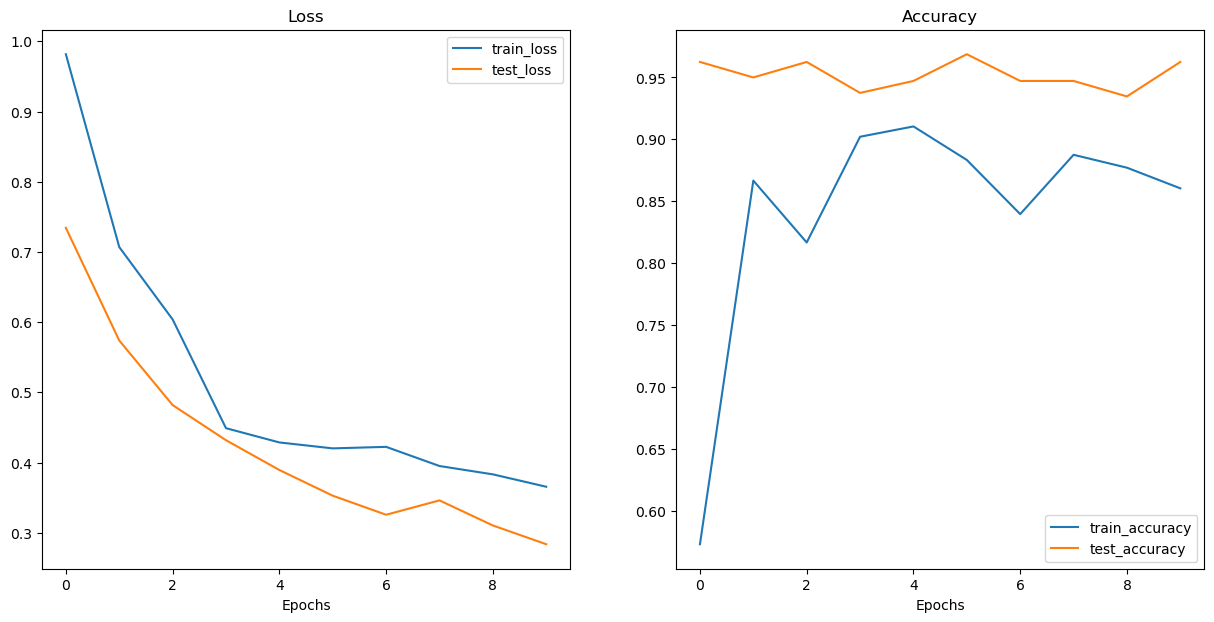

In [20]:
plot_loss_curves(effnetb2_results)

In [22]:
save_model(model = effnetb2,
           root_dir = "models",
           model_name = "finetuned_effnetb2_20percent.pth") 

Saved model to: models/finetuned_effnetb2_20percent.pth


In [26]:
effnet_size = Path("models/finetuned_effnetb2_20percent.pth").stat().st_size / (1024*1024)
print(f"EffNetB2 feature extractor model size: {effnet_size:.2f} MB")

EffNetB2 feature extractor model size: 29.83 MB


In [33]:
# Collect effnetb2 model statistics
effnetb2_total_params = sum(
    torch.numel(param) for param in effnetb2.parameters()
)
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_accuracy': effnetb2_results['test_acc'][-1],
                  'model_size (MB)': effnet_size,
                  'total_params': effnetb2_total_params}
effnetb2_stats

{'test_loss': 0.2836607605218887,
 'test_accuracy': 0.9625,
 'model_size (MB)': 29.82852077484131,
 'total_params': 7705221}

## 3. ViT Feature Extractor